[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.66352984]
['0.0', '1.3', '2.6']
[0.         1.33176492 2.663529

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


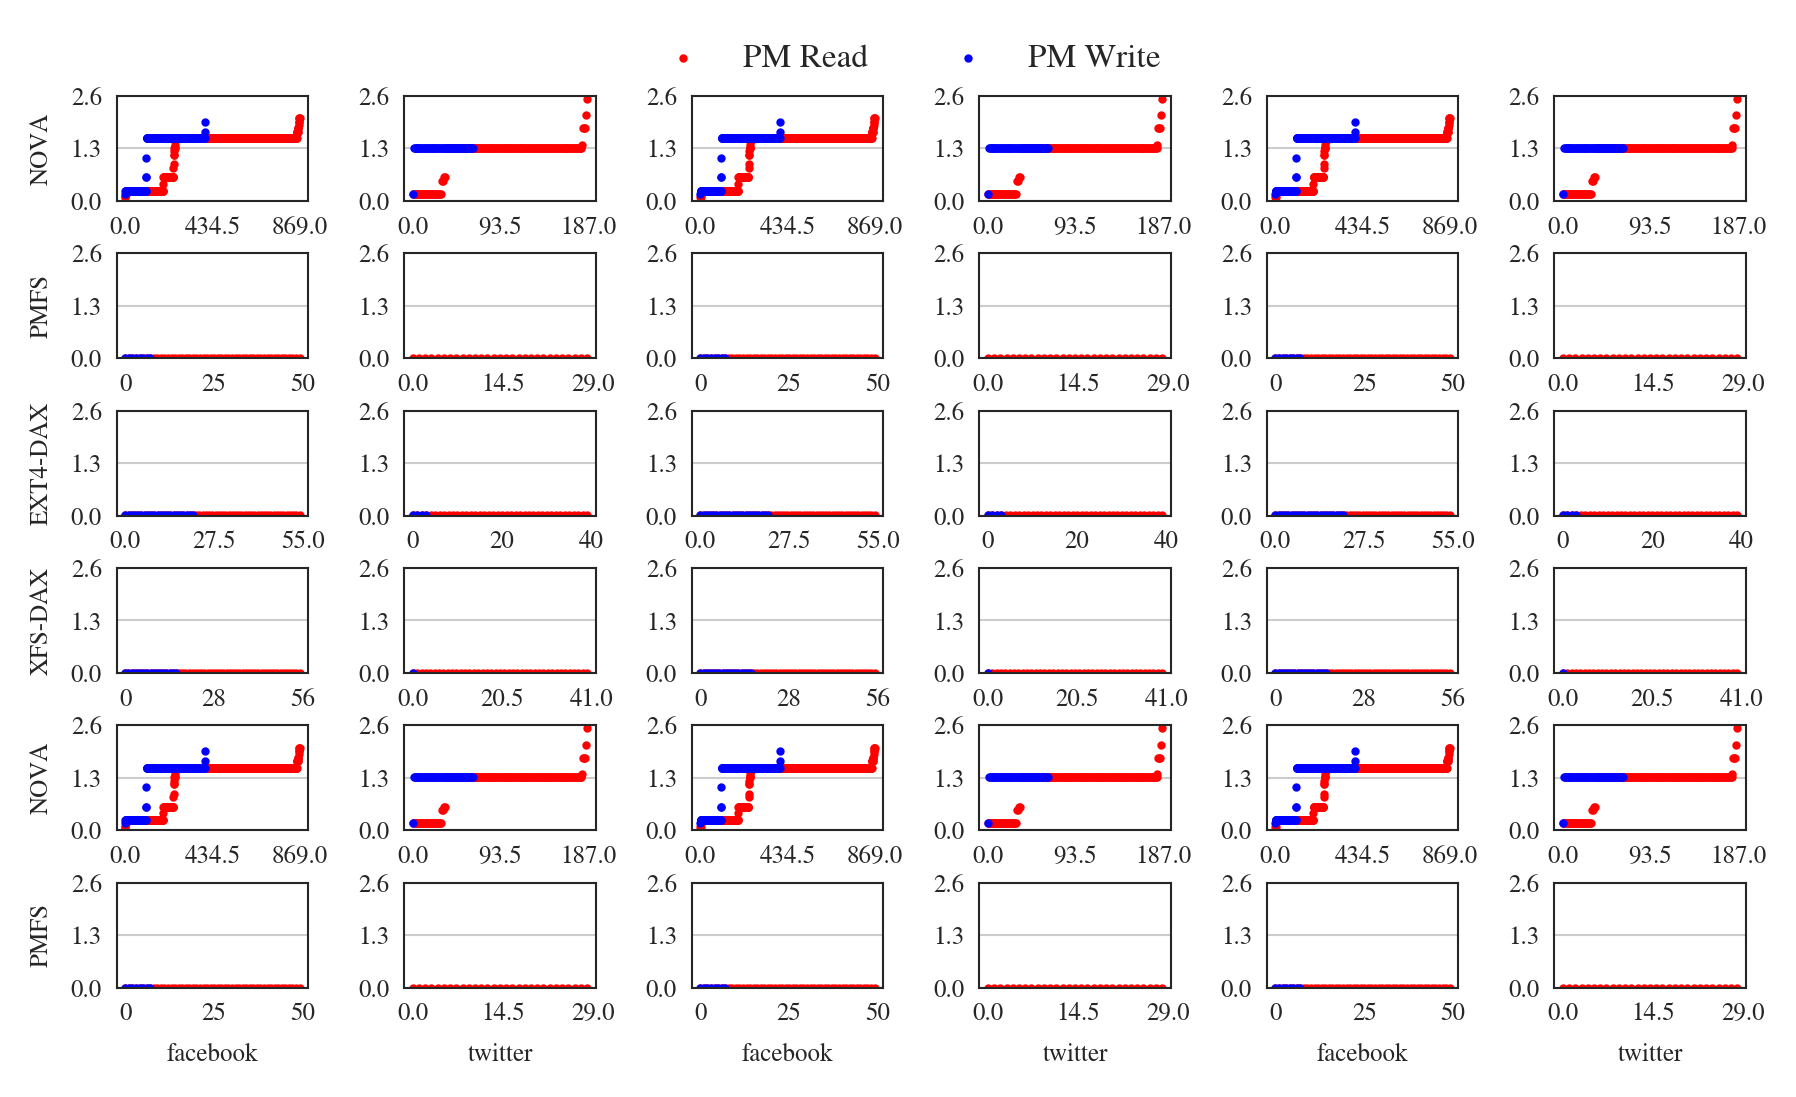

In [18]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
# with open("./performance-comparison-table", "r") as f:
#     df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(10)))

fss = [ "NOVA", "PMFS", "EXT4-DAX", "XFS-DAX", "NOVA", "PMFS" ]
workloads = [ "facebook", "twitter", "facebook", "twitter", "facebook", "twitter" ]

def format_ax_yticks(ax, yticks_low, y_ticks_high, points, valid_numbers):
    yticks = np.linspace(yticks_low, y_ticks_high, points)
    ax.set_yticks(yticks)
    min_valid_numbers = 0
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        if len(integer_numbers) > min_valid_numbers:
            min_valid_numbers = len(integer_numbers)
    
    valid_numbers = valid_numbers if valid_numbers > min_valid_numbers else min_valid_numbers
    new_yticks = []
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        decimal_numbers = ytick.split('.')[1]
        if len(decimal_numbers) < (valid_numbers - len(integer_numbers)):
            new_ytick = integer_numbers + '.' + decimal_numbers + '0' * (valid_numbers - len(integer_numbers) - len(decimal_numbers))
        else:
            new_ytick = integer_numbers + '.' + ytick.split('.')[1][:(valid_numbers - len(integer_numbers))]
        new_yticks.append(new_ytick)
    
    print(yticks)
    print(new_yticks)
    ax.set_yticklabels(new_yticks, fontsize=6)

gs = gridspec.GridSpec(len(fss), len(workloads), hspace=0.5, wspace=0.5)
for fs_idx, fs in enumerate(fss):
    for workload_idx, workload in enumerate(workloads):
        subfig = plt.subplot(gs[fs_idx, workload_idx])
        read_points = []
        write_points = []
        with open("../FIG-Traces/DATA/%s/perf_report_filtered-%s" % (fs, workload), "r") as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith("Filter Range"):
                    virt_start = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[0], 16)
                    virt_end = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[1], 16)
                elif line.startswith("read"):
                    read_points.append(int(" ".join(line.split(" ")).split(" ")[-1].strip(), 16) - virt_start)
                elif line.startswith("write"):
                    write_points.append(int(" ".join(line.split(" ")).split(" ")[-1].strip(), 16) - virt_start)
        
        read_points = [x / 100_000_000_000 for x in read_points]
        write_points = [x / 100_000_000_000 for x in write_points]
        plt.scatter(range(len(read_points)), read_points, marker='o', s=1, color='red')
        plt.scatter(range(len(write_points)), write_points, marker='o', s=1, color='blue')

        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        # plt.yticks(, fontsize=8)
        plt.ylim(0, (virt_end - virt_start) / 100_000_000_000)
        plt.xticks(np.linspace(0, len(read_points), 3), fontsize=6)
        # plt.yticks(np.linspace(0, (virt_end - virt_start) / 100_000_000_000, 3), fontsize=6)
        format_ax_yticks(ax, 0, (virt_end - virt_start) / 100_000_000_000, 3, 2)
        if fs_idx == len(fss) - 1:
            plt.xlabel(workloads[workload_idx], fontsize=6)
        if workload_idx == 0:
            plt.ylabel(fss[fs_idx], fontsize=6)
            # plt.title(subfig_titles[workload_idx], fontsize=8)
        
# legend_labels = fss
fig.legend(["PM Read", "PM Write"], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=8, frameon=False)
# plt.tight_layout()
plt.savefig("./FIG-Pattern.pdf", bbox_inches='tight', pad_inches=0)
